# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Нужно построить модель, которая по фотографии определит приблизительный возраст человека. Тренировочный датасет состоит из фотографий людей с указанием возраста.

## Исследовательский анализ данных

### Импортируем библиотеки

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Загружаем данные

In [12]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


### Проверяем данные

In [13]:
print(labels.describe())
print()
print('Количество пропусков:', labels['real_age'].isnull().sum())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000

Количество пропусков: 0


7591 изображение. Аномальных значений и пропусков нет.

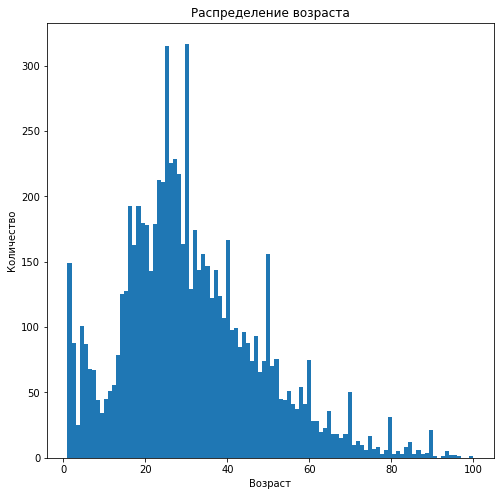

In [14]:
plt.figure(figsize=(8, 8))
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.hist(labels['real_age'], bins=100);

Больше всего фото от 18 до 40 лет. Видим, что присутствуют много фото, размеченные возрастом в 1 год. Если бы у нас была более специфичная задача, эти данные нужно было бы убрать. Но, т.к. мы работаем над решением для супермаркета – распознавание детей наоборот поможет расширить ассортимент рекомендуемых товаров.

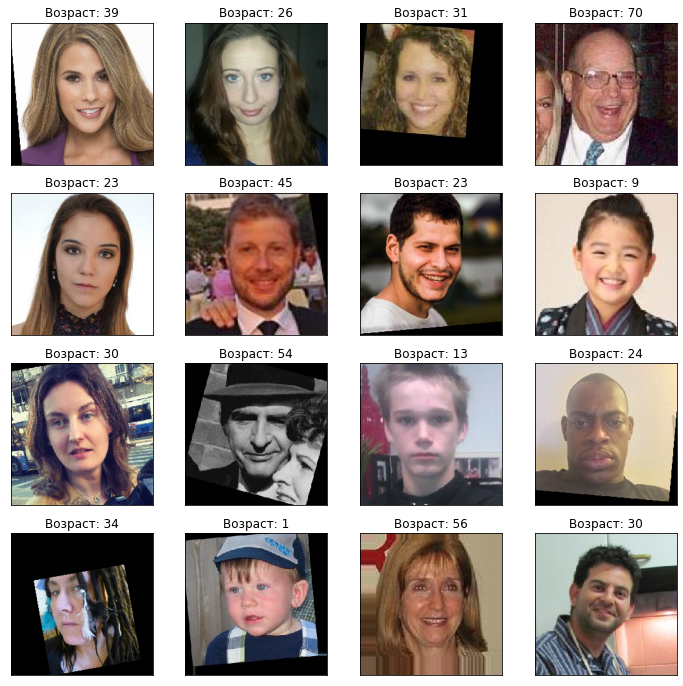

In [35]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(12,12))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Возраст: {target[i]}')

### Промежуточный вывод.

- 7591 фото - небольшая выборка;
- большинство от 18 до 40 лет;
- многие фотографии не отцентрированы и на них присутствуют черные участки;
- на некоторых лицо частично прикрыто;
- на некоторых в кадре два человека;
- яркость различается;
- есть черно-белые фото;
- само качество снимков довольно низкое. 

Все это, так или иначе, скажется на качестве оценки.

## Обучение модели

```python

import pandas as pd
import numpy as np
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    
    labels = pd.read_csv('/datasets/faces/labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255, 
                                       horizontal_flip=True, vertical_flip=True, 
                                       rotation_range=90, width_shift_range=0.3, height_shift_range=0.3)

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels, 
                                                           directory='/datasets/faces/final_files/', 
                                                           x_col='file_name', y_col='real_age',
                                                           target_size=(224, 224), batch_size=32,
                                                           class_mode='raw', subset='training', seed=12345)
    return train_datagen_flow

def load_test(path):

    labels = pd.read_csv('/datasets/faces/labels.csv')

    valid_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

    valid_gen_flow = valid_datagen.flow_from_dataframe(dataframe=labels, 
                                                       directory='/datasets/faces/final_files/', 
                                                       x_col='file_name', y_col='real_age', 
                                                       target_size=(224, 224), batch_size=32,
                                                       class_mode='raw', subset='validation', seed=12345)
    return valid_gen_flow

def create_model(input_shape):
   
    backbone = ResNet50(input_shape = input_shape, weights = 'imagenet', include_top = False) 

    optimizer = Adam(lr = 0.0001)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):    
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Train for 178 steps, validate for 60 steps

Epoch 1/10
178/178 - 48s - loss: 257.7835 - mae: 11.6256 - val_loss: 991.9040 - val_mae: 26.7773

Epoch 2/10
178/178 - 39s - loss: 103.7312 - mae: 7.6830 - val_loss: 704.1902 - val_mae: 21.2827

Epoch 3/10
178/178 - 39s - loss: 81.4931 - mae: 6.7932 - val_loss: 247.1754 - val_mae: 12.3684

Epoch 4/10
178/178 - 39s - loss: 66.0573 - mae: 6.1604 - val_loss: 110.4337 - val_mae: 8.0236

Epoch 5/10
178/178 - 39s - loss: 53.3204 - mae: 5.4926 - val_loss: 99.7691 - val_mae: 7.5479

Epoch 6/10
178/178 - 39s - loss: 43.7979 - mae: 5.0950 - val_loss: 77.5170 - val_mae: 6.7026

Epoch 7/10
178/178 - 39s - loss: 41.1224 - mae: 4.8454 - val_loss: 78.0264 - val_mae: 6.5276

Epoch 8/10
178/178 - 39s - loss: 33.1373 - mae: 4.4181 - val_loss: 79.5248 - val_mae: 6.6928

Epoch 9/10
178/178 - 40s - loss: 28.8656 - mae: 4.0983 - val_loss: 82.7041 - val_mae: 6.6614

Epoch 10/10
178/178 - 40s - loss: 25.5664 - mae: 3.8510 - val_loss: 75.4385 - val_mae: 6.5489

Test MAE: 6.5489

```

## Анализ обученной модели

Для решения задачи мы использовали предобученную модель сверточной сети с архитектурой RenNet50. Дообучение просходило на хорошо подготовленном датасете с 7591 изображениями. Видим, что значение функции потерь и итоговой метрики со временем уменьшаются, значит, переобучения нет. Необходимое значение целевой метрики было достигнуто.